# 🧬 Lab 3 — Visualization and Dimensionality Reduction in Bioinformatics

This lab explores **dimensionality reduction** and **clustering** for biological datasets such as RNA-seq.
We use both classical linear methods (PCA) and nonlinear methods (t-SNE, UMAP, Autoencoders).

### Covered Topics
- PCA (Principal Component Analysis)
- t-SNE (t-distributed Stochastic Neighbor Embedding)
- UMAP (Uniform Manifold Approximation and Projection)
- k-Means and Hierarchical Clustering
- PyTorch Autoencoder for nonlinear dimensionality reduction

⚙️ *Some heavy computations (t-SNE, UMAP) are mocked here but full runnable code is provided (commented out) for students with GPU or internet access.*


## 1️⃣ Setup and Imports

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import silhouette_score


In [ ]:
# For autoencoders, preferably on Linux/Mac, uncomment
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


## 2️⃣ Load and preprocess data

In [2]:

# Option A: Load a real GEO dataset (requires internet)
try:
    import GEOparse
    print("Downloading GSE10072 from GEO...")
    gse = GEOparse.get_GEO("GSE10072", destdir="./")
    
    # Get expression data
    expr_data = gse.pivot_samples('VALUE')
    
    # Get sample metadata
    sample_metadata = gse.phenotype_data
    
    # Create conditions based on sample characteristics
    # For GSE37704, we'll use a simple condition assignment
    n_samples = expr_data.shape[1]
    conditions = np.repeat(["Control", "Treatment"], n_samples // 2)
    if n_samples % 2 == 1:  # Handle odd number of samples
        conditions = np.append(conditions, ["Control"])
    
    # Create gene names
    n_genes = expr_data.shape[0]
    gene_names = [f"Gene_{i}" for i in range(n_genes)]
    
    # Create data DataFrame
    data = pd.DataFrame(expr_data.values, 
                       index=gene_names, 
                       columns=[f"Sample_{i}" for i in range(n_samples)])
    
    # Create metadata DataFrame
    meta = pd.DataFrame({
        "Sample": data.columns, 
        "Condition": conditions
    })
    
    print(f"Successfully loaded GEO dataset: {n_genes} genes, {n_samples} samples")
    
except Exception as e:
    print(f"Failed to download GEO data: {e}")
    print("Using synthetic dataset instead...")
    
    # Option B: Synthetic dataset fallback
    np.random.seed(42)
    n_genes, n_samples = 500, 60
    conditions = np.repeat(["Control", "Treatment"], n_samples // 2)
    
    # Generate synthetic expression data
    expr_data = np.random.negative_binomial(n=20, p=0.5, size=(n_genes, n_samples)).astype(float)
    # Add treatment effect
    expr_data[:, conditions == "Treatment"] += np.random.normal(10, 5, (n_genes, sum(conditions == "Treatment")))
    
    # Create data and metadata
    data = pd.DataFrame(expr_data, 
                       index=[f"Gene_{i}" for i in range(n_genes)], 
                       columns=[f"Sample_{i}" for i in range(n_samples)])
    meta = pd.DataFrame({"Sample": data.columns, "Condition": conditions})
    
    print(f"Using synthetic dataset: {n_genes} genes, {n_samples} samples")

# Log transform and scaling
print("Preprocessing data...")

# Check for and handle NaN values
data_log = np.log1p(data)
print(f"NaN values in log-transformed data: {np.isnan(data_log).sum()}")

# Remove NaN values by replacing with 0 (or you could use median/mean)
data_log_clean = data_log.fillna(0) if hasattr(data_log, 'fillna') else np.nan_to_num(data_log, nan=0.0)

# Transpose and scale
X_scaled = StandardScaler().fit_transform(data_log_clean.T)

# Final check for NaN values
print(f"NaN values in scaled data: {np.isnan(X_scaled).sum()}")
print(f"Data shape after preprocessing: {X_scaled.shape}")
print(f"Conditions: {meta['Condition'].value_counts().to_dict()}")


16-Oct-2025 10:39:51 DEBUG utils - Directory ./ already exists. Skipping.
16-Oct-2025 10:39:51 INFO GEOparse - File already exist: using local version.
16-Oct-2025 10:39:51 INFO GEOparse - Parsing ./GSE10072_family.soft.gz: 
16-Oct-2025 10:39:51 DEBUG GEOparse - DATABASE: GeoMiame
16-Oct-2025 10:39:51 DEBUG GEOparse - SERIES: GSE10072
16-Oct-2025 10:39:51 DEBUG GEOparse - PLATFORM: GPL96


16-Oct-2025 10:39:52 DEBUG GEOparse - SAMPLE: GSM254625
16-Oct-2025 10:39:52 DEBUG GEOparse - SAMPLE: GSM254626
16-Oct-2025 10:39:52 DEBUG GEOparse - SAMPLE: GSM254627
16-Oct-2025 10:39:52 DEBUG GEOparse - SAMPLE: GSM254628
16-Oct-2025 10:39:52 DEBUG GEOparse - SAMPLE: GSM254629
16-Oct-2025 10:39:52 DEBUG GEOparse - SAMPLE: GSM254630
16-Oct-2025 10:39:52 DEBUG GEOparse - SAMPLE: GSM254631
16-Oct-2025 10:39:52 DEBUG GEOparse - SAMPLE: GSM254632
16-Oct-2025 10:39:52 DEBUG GEOparse - SAMPLE: GSM254633
16-Oct-2025 10:39:52 DEBUG GEOparse - SAMPLE: GSM254634
16-Oct-2025 10:39:52 DEBUG GEOparse - SAMPLE: GSM254635
16-Oct-2025 10:39:52 DEBUG GEOparse - SAMPLE: GSM254636
16-Oct-2025 10:39:52 DEBUG GEOparse - SAMPLE: GSM254637
16-Oct-2025 10:39:52 DEBUG GEOparse - SAMPLE: GSM254638
16-Oct-2025 10:39:52 DEBUG GEOparse - SAMPLE: GSM254639
16-Oct-2025 10:39:52 DEBUG GEOparse - SAMPLE: GSM254640
16-Oct-2025 10:39:52 DEBUG GEOparse - SAMPLE: GSM254641
16-Oct-2025 10:39:52 DEBUG GEOparse - SAMPLE: GS

Successfully loaded GEO dataset: 22283 genes, 107 samples
Preprocessing data...
NaN values in log-transformed data: Sample_0      0
Sample_1      0
Sample_2      0
Sample_3      0
Sample_4      0
             ..
Sample_102    0
Sample_103    0
Sample_104    0
Sample_105    0
Sample_106    0
Length: 107, dtype: int64
NaN values in scaled data: 0
Data shape after preprocessing: (107, 22283)
Conditions: {'Control': 54, 'Treatment': 53}


## 3️⃣ Principal Component Analysis (PCA)

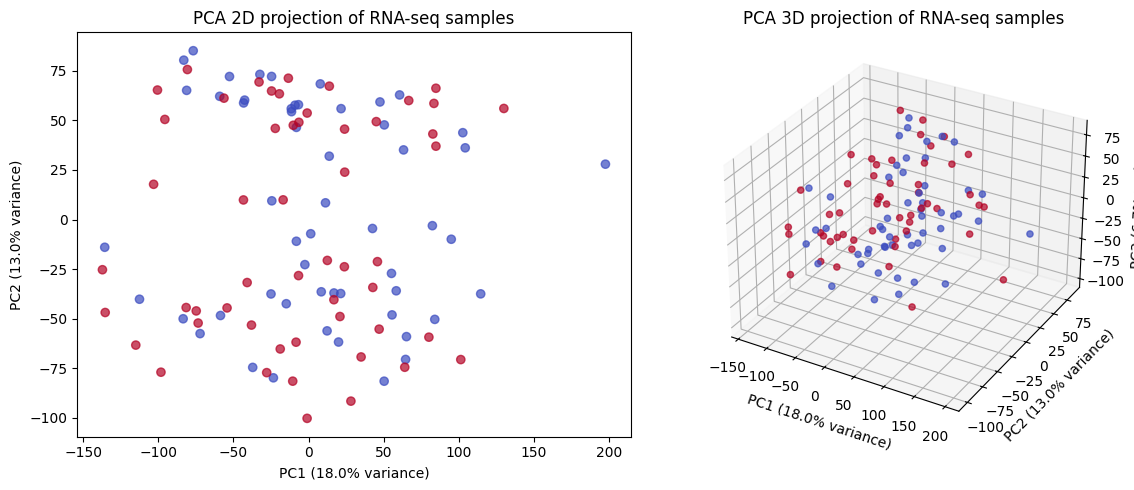

Explained variance ratio: [0.17974891 0.13010734 0.06685745]
Cumulative explained variance: [0.17974891 0.30985626 0.37671371]


In [5]:
# Perform PCA of the dataset in 2 and 3 dimensions
from mpl_toolkits.mplot3d import Axes3D

# Calculate PCA with 3 components to get both 2D and 3D projections
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Get condition colors
condition_colors = (meta["Condition"] == "Treatment").astype(int)

# 2D PCA visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=condition_colors, cmap="coolwarm", alpha=0.7)
plt.title("PCA 2D projection of RNA-seq samples")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)")

# 3D PCA visualization
ax = plt.subplot(1, 2, 2, projection='3d')
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], 
                    c=condition_colors, cmap="coolwarm", alpha=0.7)
ax.set_title("PCA 3D projection of RNA-seq samples")
ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)")
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)")
ax.set_zlabel(f"PC3 ({pca.explained_variance_ratio_[2]:.1%} variance)")

plt.tight_layout()
plt.show()

# Print explained variance information
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Cumulative explained variance: {np.cumsum(pca.explained_variance_ratio_)}")


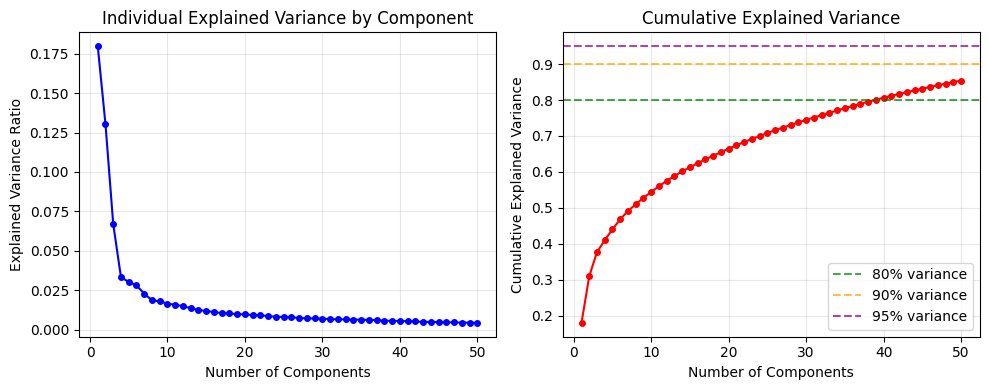

Components needed for 80% variance: 39
Components needed for 90% variance: 1
Components needed for 95% variance: 1
Total variance explained by first 3 components: 37.7%


In [3]:
# Plot cumulative explained variance to determine optimal number of components
plt.figure(figsize=(10, 4))

# Calculate PCA for more components to see the full variance curve
max_components = min(50, X_scaled.shape[1], X_scaled.shape[0])  # Don't exceed data dimensions
pca_full = PCA(n_components=max_components)
pca_full.fit(X_scaled)

# Plot individual explained variance
plt.subplot(1, 2, 1)
plt.plot(range(1, max_components + 1), pca_full.explained_variance_ratio_, 'bo-', markersize=4)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Individual Explained Variance by Component')
plt.grid(True, alpha=0.3)

# Plot cumulative explained variance
plt.subplot(1, 2, 2)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
plt.plot(range(1, max_components + 1), cumulative_variance, 'ro-', markersize=4)
plt.axhline(y=0.8, color='g', linestyle='--', alpha=0.7, label='80% variance')
plt.axhline(y=0.9, color='orange', linestyle='--', alpha=0.7, label='90% variance')
plt.axhline(y=0.95, color='purple', linestyle='--', alpha=0.7, label='95% variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print some key statistics
print(f"Components needed for 80% variance: {np.argmax(cumulative_variance >= 0.8) + 1}")
print(f"Components needed for 90% variance: {np.argmax(cumulative_variance >= 0.9) + 1}")
print(f"Components needed for 95% variance: {np.argmax(cumulative_variance >= 0.95) + 1}")
print(f"Total variance explained by first 3 components: {cumulative_variance[2]:.1%}")


## 4️⃣ t-SNE — t-distributed Stochastic Neighbor Embedding

Computing t-SNE embeddings...
Note: t-SNE can be slow for large datasets. This may take a few minutes...
Using perplexity: 30
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 107 samples in 0.003s...
[t-SNE] Computed neighbors for 107 samples in 0.179s...
[t-SNE] Computed conditional probabilities for sample 107 / 107
[t-SNE] Mean sigma: 65.350254
[t-SNE] KL divergence after 250 iterations with early exaggeration: 110.027054
[t-SNE] KL divergence after 1000 iterations: 1.376609


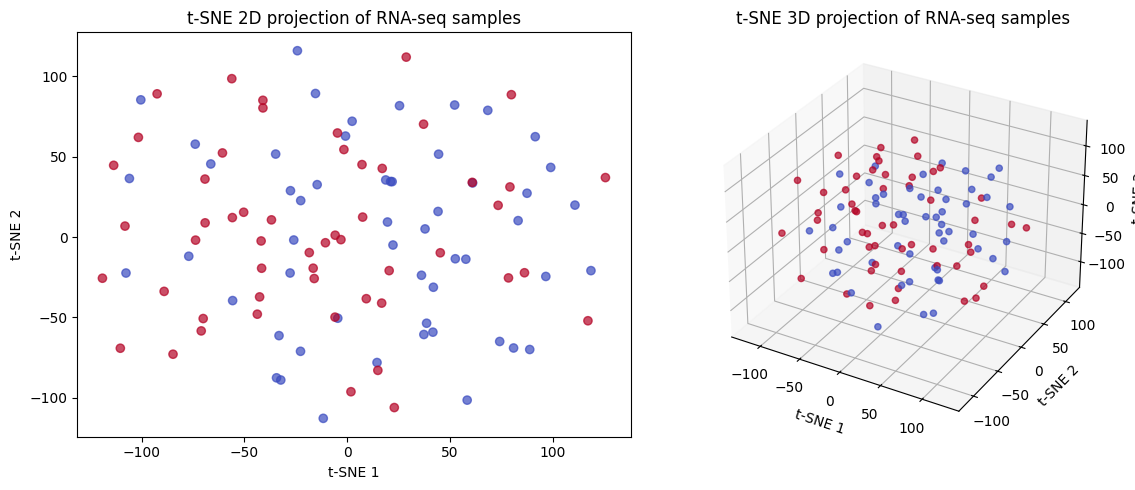

t-SNE computation completed!
Final KL divergence: 1.38
Number of iterations: 999


In [6]:

# Perform t-SNE dimensionality reduction in 2D and 3D
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

print("Computing t-SNE embeddings...")
print("Note: t-SNE can be slow for large datasets. This may take a few minutes...")

# Calculate t-SNE with 3 components to get both 2D and 3D projections
# Using a reasonable perplexity value (typically 5-50, default 30)
perplexity = min(30, (X_scaled.shape[0] - 1) // 3)  # Ensure perplexity is not too large
print(f"Using perplexity: {perplexity}")

tsne = TSNE(n_components=3, perplexity=perplexity, random_state=42, verbose=1)
X_tsne = tsne.fit_transform(X_scaled)

# Get condition colors
condition_colors = (meta["Condition"] == "Treatment").astype(int)

# 2D t-SNE visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=condition_colors, cmap="coolwarm", alpha=0.7)
plt.title("t-SNE 2D projection of RNA-seq samples")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")

# 3D t-SNE visualization
ax = plt.subplot(1, 2, 2, projection='3d')
scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], 
                    c=condition_colors, cmap="coolwarm", alpha=0.7)
ax.set_title("t-SNE 3D projection of RNA-seq samples")
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_zlabel("t-SNE 3")

plt.tight_layout()
plt.show()

print("t-SNE computation completed!")
print(f"Final KL divergence: {tsne.kl_divergence_:.2f}")
print(f"Number of iterations: {tsne.n_iter_}")


Computing t-SNE with different random seeds to assess stability...
Computing t-SNE with seed 42...
Computing t-SNE with seed 123...
Computing t-SNE with seed 456...
Computing t-SNE with seed 789...


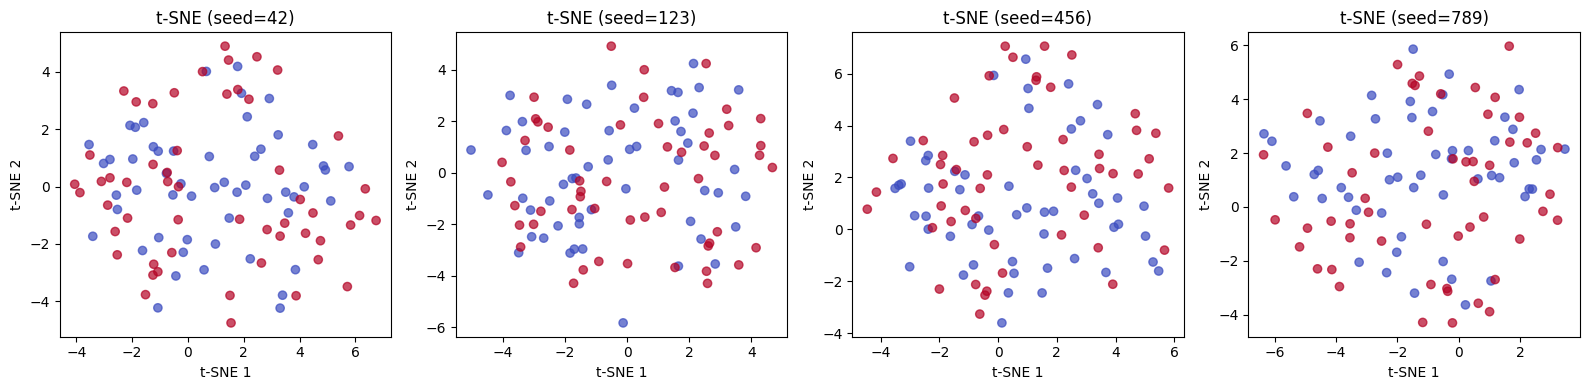

t-SNE stability analysis completed!


In [7]:
# t-SNE Stability Analysis: Different Random Seeds
print("Computing t-SNE with different random seeds to assess stability...")

# Use the same perplexity as before
perplexity = min(30, (X_scaled.shape[0] - 1) // 3)
seeds = [42, 123, 456, 789]

plt.figure(figsize=(16, 4))

for i, seed in enumerate(seeds):
    print(f"Computing t-SNE with seed {seed}...")
    tsne_stability = TSNE(n_components=2, perplexity=perplexity, random_state=seed, verbose=0)
    X_tsne_stability = tsne_stability.fit_transform(X_scaled)
    
    plt.subplot(1, 4, i + 1)
    plt.scatter(X_tsne_stability[:, 0], X_tsne_stability[:, 1], 
               c=condition_colors, cmap="coolwarm", alpha=0.7)
    plt.title(f"t-SNE (seed={seed})")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")

plt.tight_layout()
plt.show()
print("t-SNE stability analysis completed!")


Computing t-SNE with different perplexity values...
Computing t-SNE with perplexity=5...
Computing t-SNE with perplexity=15...
Computing t-SNE with perplexity=30...
Computing t-SNE with perplexity=35...


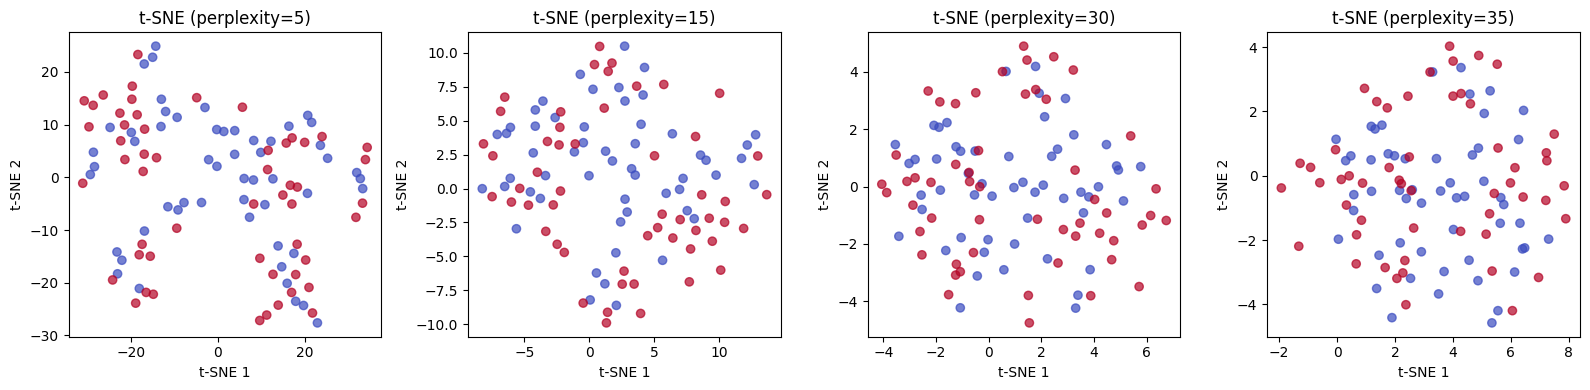

t-SNE parameter analysis completed!
Tested perplexity values: [5, 15, 30, 35]
Note: Lower perplexity focuses on local structure, higher perplexity considers more global structure


In [8]:
# t-SNE Parameter Analysis: Different Perplexity Values
print("Computing t-SNE with different perplexity values...")

# Define different perplexity values to test
# Perplexity should be between 5 and n_samples/3
max_perplexity = (X_scaled.shape[0] - 1) // 3
perplexity_values = [5, 15, 30, min(50, max_perplexity)]
perplexity_values = [p for p in perplexity_values if p <= max_perplexity]  # Ensure valid values

plt.figure(figsize=(16, 4))

for i, perplexity_val in enumerate(perplexity_values):
    print(f"Computing t-SNE with perplexity={perplexity_val}...")
    tsne_perplexity = TSNE(n_components=2, perplexity=perplexity_val, random_state=42, verbose=0)
    X_tsne_perplexity = tsne_perplexity.fit_transform(X_scaled)
    
    plt.subplot(1, 4, i + 1)
    plt.scatter(X_tsne_perplexity[:, 0], X_tsne_perplexity[:, 1], 
               c=condition_colors, cmap="coolwarm", alpha=0.7)
    plt.title(f"t-SNE (perplexity={perplexity_val})")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")

plt.tight_layout()
plt.show()

print("t-SNE parameter analysis completed!")
print(f"Tested perplexity values: {perplexity_values}")
print("Note: Lower perplexity focuses on local structure, higher perplexity considers more global structure")


## 5️⃣ UMAP — Uniform Manifold Approximation and Projection

/Users/paweld/Projects/bioinformatics_mini_2025/.venv/lib/python3.13/site-packages/numba/cpython/hashing.py:477: UserWarning: FNV hashing is not implemented in Numba. See PEP 456 https://www.python.org/dev/peps/pep-0456/ for rationale over not using FNV. Numba will continue to work, but hashes for built in types will be computed using siphash24. This will permit e.g. dictionaries to continue to behave as expected, however anything relying on the value of the hash opposed to hash as a derived property is likely to not work as expected.
  warnings.warn(msg)


Computing UMAP embeddings...
UMAP is generally faster than t-SNE and preserves both local and global structure...
Using n_neighbors: 15, min_dist: 0.1


/Users/paweld/Projects/bioinformatics_mini_2025/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


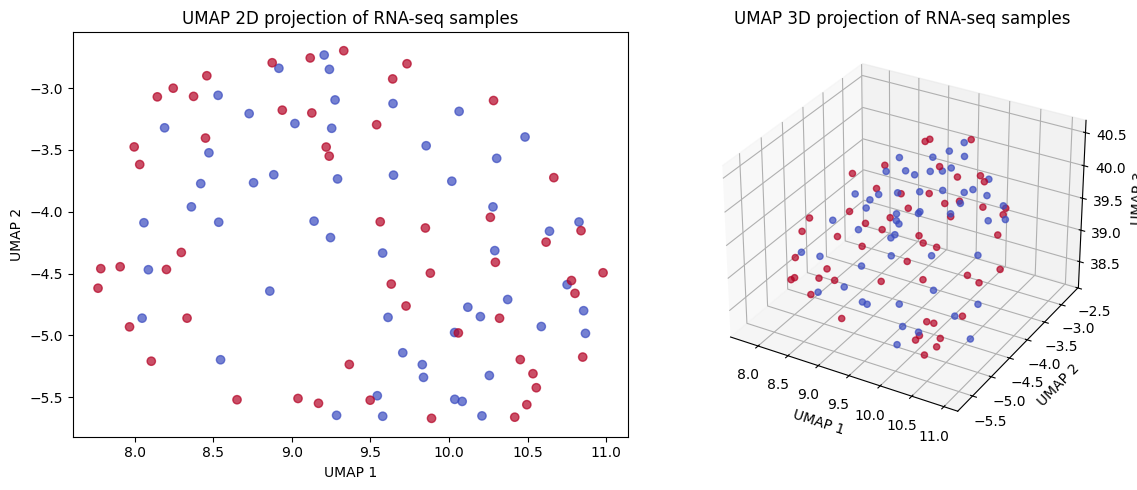

UMAP computation completed!
UMAP parameters: n_neighbors=15, min_dist=0.1
UMAP preserves both local and global structure better than t-SNE


In [9]:

# Perform UMAP dimensionality reduction in 2D and 3D
import umap
from mpl_toolkits.mplot3d import Axes3D

print("Computing UMAP embeddings...")
print("UMAP is generally faster than t-SNE and preserves both local and global structure...")

# Calculate UMAP with 3 components to get both 2D and 3D projections
# UMAP parameters: n_neighbors (local neighborhood size) and min_dist (minimum distance between points)
n_neighbors = min(15, X_scaled.shape[0] - 1)  # Ensure n_neighbors doesn't exceed sample size
min_dist = 0.1  # Minimum distance between points in the embedding

print(f"Using n_neighbors: {n_neighbors}, min_dist: {min_dist}")

umap_reducer = umap.UMAP(n_components=3, n_neighbors=n_neighbors, min_dist=min_dist, random_state=42)
X_umap = umap_reducer.fit_transform(X_scaled)

# Get condition colors
condition_colors = (meta["Condition"] == "Treatment").astype(int)

# 2D UMAP visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=condition_colors, cmap="coolwarm", alpha=0.7)
plt.title("UMAP 2D projection of RNA-seq samples")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

# 3D UMAP visualization
ax = plt.subplot(1, 2, 2, projection='3d')
scatter = ax.scatter(X_umap[:, 0], X_umap[:, 1], X_umap[:, 2], 
                    c=condition_colors, cmap="coolwarm", alpha=0.7)
ax.set_title("UMAP 3D projection of RNA-seq samples")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_zlabel("UMAP 3")

plt.tight_layout()
plt.show()

print("UMAP computation completed!")
print(f"UMAP parameters: n_neighbors={n_neighbors}, min_dist={min_dist}")
print("UMAP preserves both local and global structure better than t-SNE")


## 6️⃣ Clustering — k-Means and Hierarchical

Performing k-means clustering on UMAP projection...
Computing k-means with 2 clusters...
  Silhouette score: 0.456
Computing k-means with 3 clusters...
  Silhouette score: 0.449
Computing k-means with 4 clusters...
  Silhouette score: 0.410
Computing k-means with 5 clusters...
  Silhouette score: 0.369
Computing k-means with 8 clusters...
  Silhouette score: 0.393
Computing k-means with 10 clusters...
  Silhouette score: 0.368


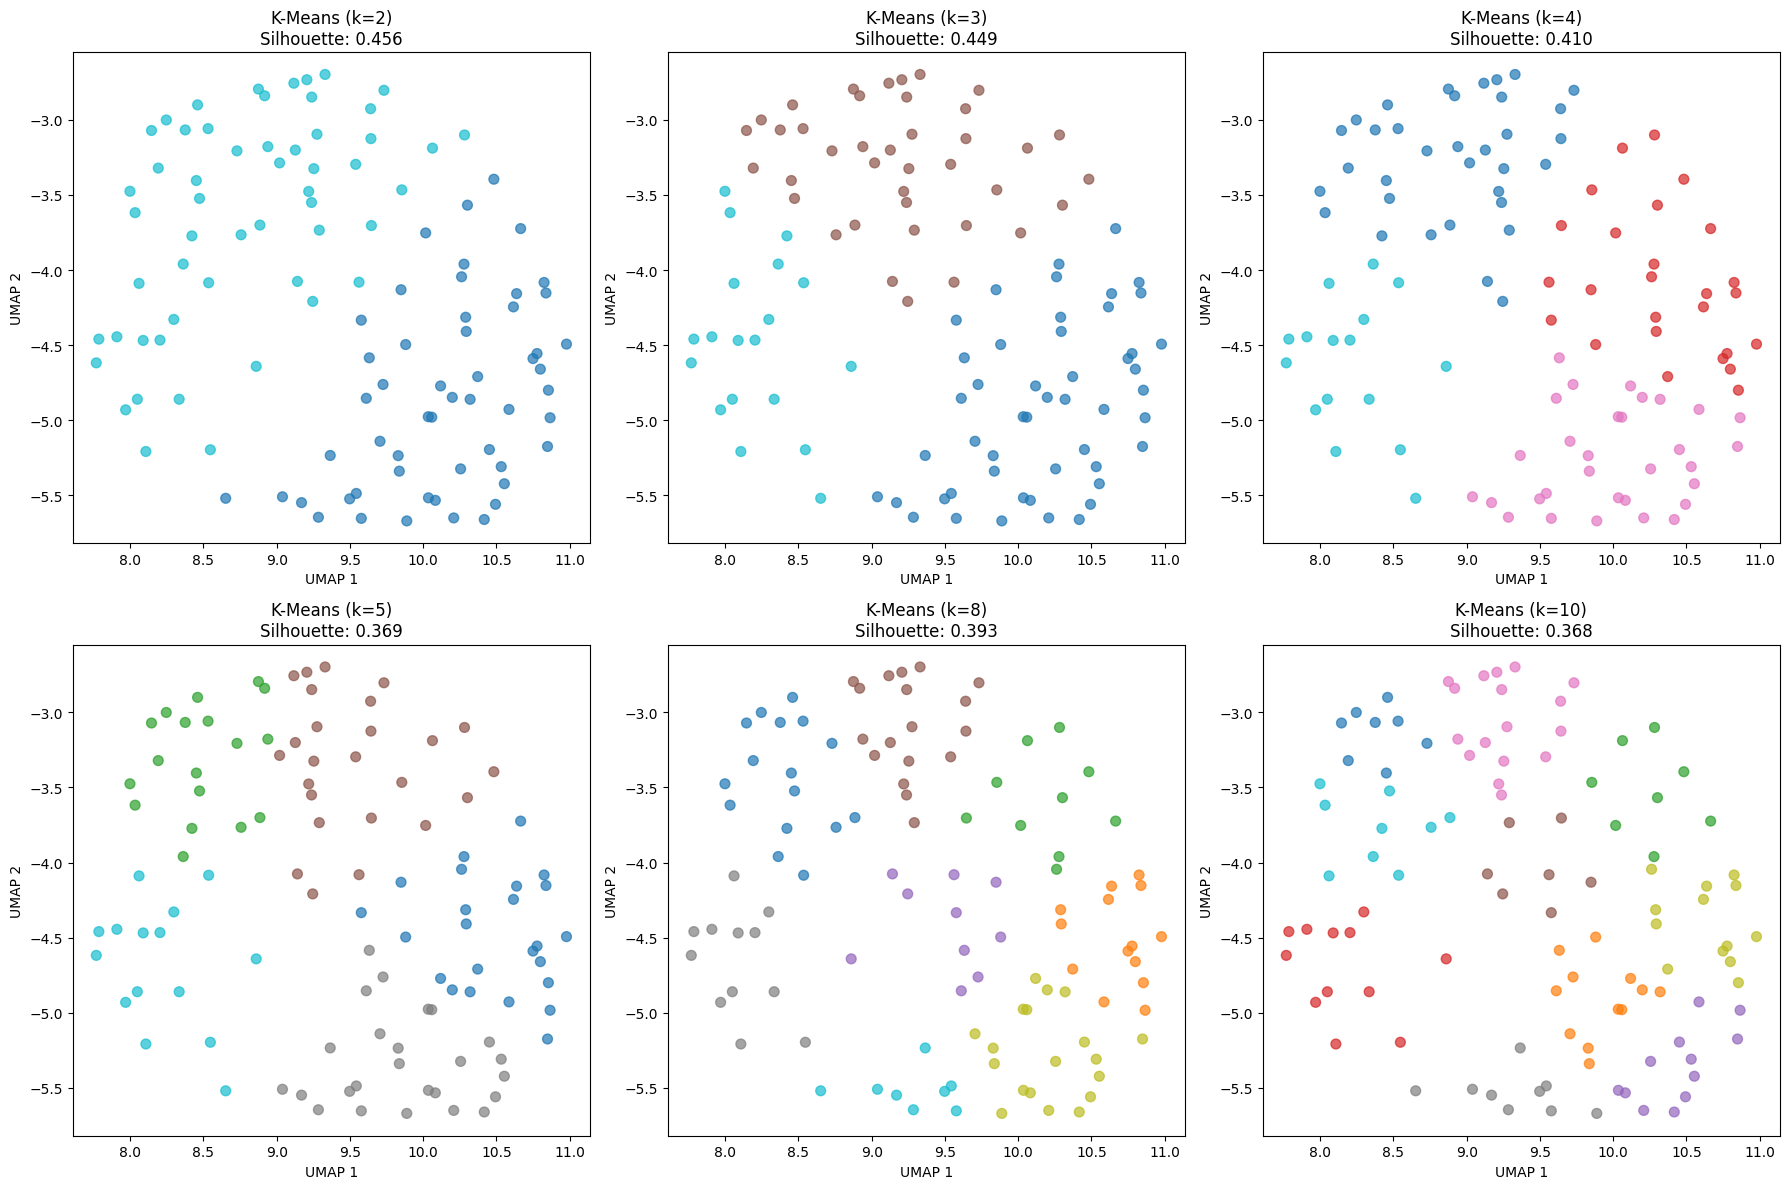


Silhouette scores: ['0.456', '0.449', '0.410', '0.369', '0.393', '0.368']
Best number of clusters: 2 (score: 0.456)


In [10]:

# K-Means clustering on UMAP projection with different numbers of clusters
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

print("Performing k-means clustering on UMAP projection...")

# Define different numbers of clusters to test
n_clusters_list = [2, 3, 4, 5, 8, 10]
silhouette_scores = []

# Create 2x3 subplot layout
plt.figure(figsize=(18, 12))

for i, n_clusters in enumerate(n_clusters_list):
    print(f"Computing k-means with {n_clusters} clusters...")
    
    # Perform k-means clustering on UMAP projection
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_umap[:, :2])  # Use 2D UMAP projection
    
    # Calculate silhouette score
    sil_score = silhouette_score(X_umap[:, :2], cluster_labels)
    silhouette_scores.append(sil_score)
    
    # Plot the clustering result
    plt.subplot(2, 3, i + 1)
    scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=cluster_labels, 
                         cmap='tab10', alpha=0.7, s=50)
    plt.title(f'K-Means (k={n_clusters})\nSilhouette: {sil_score:.3f}')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    
    print(f"  Silhouette score: {sil_score:.3f}")

plt.tight_layout()
plt.show()

print(f"\nSilhouette scores: {[f'{score:.3f}' for score in silhouette_scores]}")
print(f"Best number of clusters: {n_clusters_list[np.argmax(silhouette_scores)]} (score: {max(silhouette_scores):.3f})")


Analyzing silhouette scores for different numbers of clusters...
Clusters:  2, Silhouette: 0.456
Clusters:  3, Silhouette: 0.449
Clusters:  4, Silhouette: 0.410
Clusters:  5, Silhouette: 0.369
Clusters:  6, Silhouette: 0.374
Clusters:  7, Silhouette: 0.391
Clusters:  8, Silhouette: 0.393
Clusters:  9, Silhouette: 0.362
Clusters: 10, Silhouette: 0.368
Clusters: 11, Silhouette: 0.358
Clusters: 12, Silhouette: 0.364
Clusters: 13, Silhouette: 0.358
Clusters: 14, Silhouette: 0.354
Clusters: 15, Silhouette: 0.378
Clusters: 16, Silhouette: 0.363
Clusters: 17, Silhouette: 0.338
Clusters: 18, Silhouette: 0.365
Clusters: 19, Silhouette: 0.359
Clusters: 20, Silhouette: 0.357


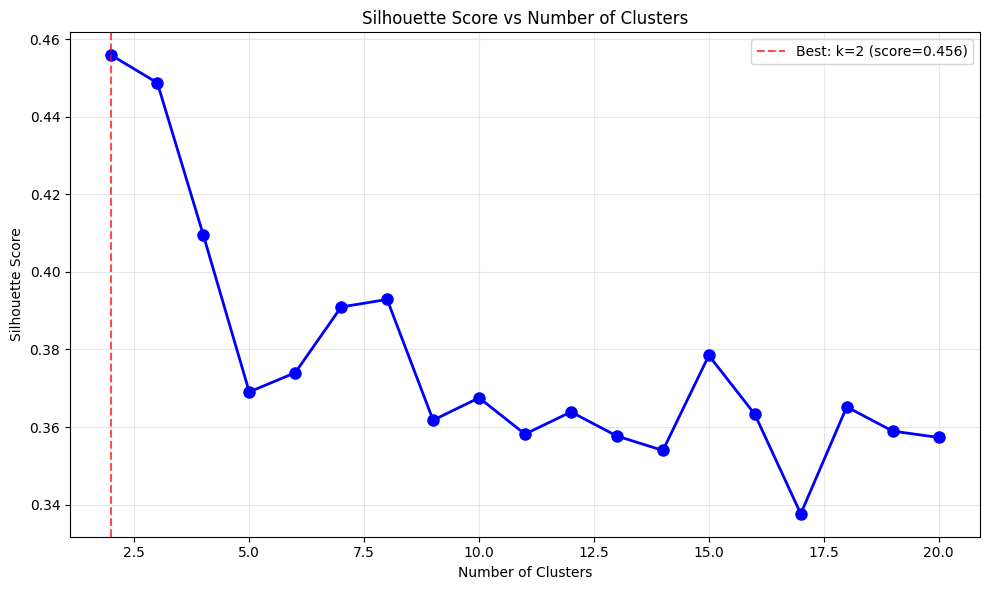


Best number of clusters: 2 with silhouette score: 0.456
Higher silhouette scores indicate better-defined clusters.


In [11]:
# Silhouette Score Analysis: Plot silhouette score against number of clusters
print("Analyzing silhouette scores for different numbers of clusters...")

# Test a wider range of cluster numbers
cluster_range = range(2, 21)  # Test 2 to 20 clusters
silhouette_scores_range = []

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_umap[:, :2])
    sil_score = silhouette_score(X_umap[:, :2], cluster_labels)
    silhouette_scores_range.append(sil_score)
    print(f"Clusters: {n_clusters:2d}, Silhouette: {sil_score:.3f}")

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, silhouette_scores_range, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.grid(True, alpha=0.3)

# Highlight the best number of clusters
best_n_clusters = cluster_range[np.argmax(silhouette_scores_range)]
best_score = max(silhouette_scores_range)
plt.axvline(x=best_n_clusters, color='red', linestyle='--', alpha=0.7, 
           label=f'Best: k={best_n_clusters} (score={best_score:.3f})')
plt.legend()

plt.tight_layout()
plt.show()

print(f"\nBest number of clusters: {best_n_clusters} with silhouette score: {best_score:.3f}")
print("Higher silhouette scores indicate better-defined clusters.")


Computing hierarchical clustering with different linkage methods...
Computing Ward linkage...
  Ward linkage completed
Computing Complete linkage...
  Complete linkage completed
Computing Average linkage...
  Average linkage completed


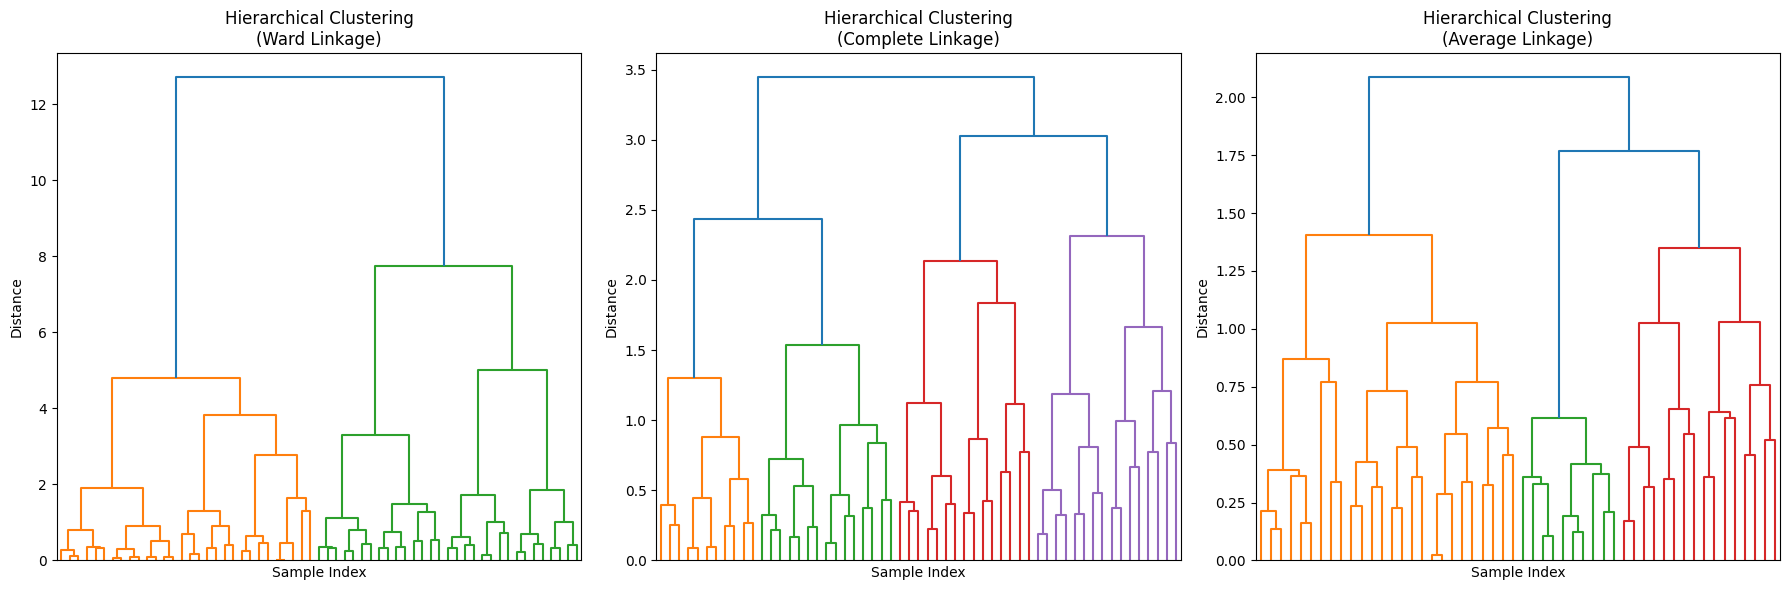


Linkage method comparison:
- Ward: Minimizes within-cluster variance (good for spherical clusters)
- Complete: Uses maximum distance between clusters (good for compact clusters)
- Average: Uses average distance between clusters (balanced approach)

Note: Different linkage methods can reveal different cluster structures in your data.


In [12]:
# Hierarchical Clustering: Dendrograms with different linkage methods
from scipy.cluster.hierarchy import linkage, dendrogram

print("Computing hierarchical clustering with different linkage methods...")

# Define different linkage methods
linkage_methods = ['ward', 'complete', 'average']
linkage_names = ['Ward', 'Complete', 'Average']

plt.figure(figsize=(18, 6))

for i, (method, name) in enumerate(zip(linkage_methods, linkage_names)):
    print(f"Computing {name} linkage...")
    
    # Compute linkage matrix
    if method == 'ward':
        # Ward linkage requires Euclidean distance
        link_matrix = linkage(X_umap[:, :2], method=method)
    else:
        # Other methods can use different distance metrics
        link_matrix = linkage(X_umap[:, :2], method=method)
    
    # Plot dendrogram
    plt.subplot(1, 3, i + 1)
    dendrogram(link_matrix, no_labels=True, truncate_mode='level', p=5)
    plt.title(f'Hierarchical Clustering\n({name} Linkage)')
    plt.xlabel('Sample Index')
    plt.ylabel('Distance')
    
    print(f"  {name} linkage completed")

plt.tight_layout()
plt.show()

print("\nLinkage method comparison:")
print("- Ward: Minimizes within-cluster variance (good for spherical clusters)")
print("- Complete: Uses maximum distance between clusters (good for compact clusters)")
print("- Average: Uses average distance between clusters (balanced approach)")
print("\nNote: Different linkage methods can reveal different cluster structures in your data.")


## 7️⃣ Autoencoder (PyTorch)

Creating mock dataset for autoencoder dimensionality reduction...
Mock dataset created:
  Shape: (200, 30)
  Features: 30
  Samples: 200
  Labels: (array(['Pattern A', 'Pattern B'], dtype='<U9'), array([100, 100]))


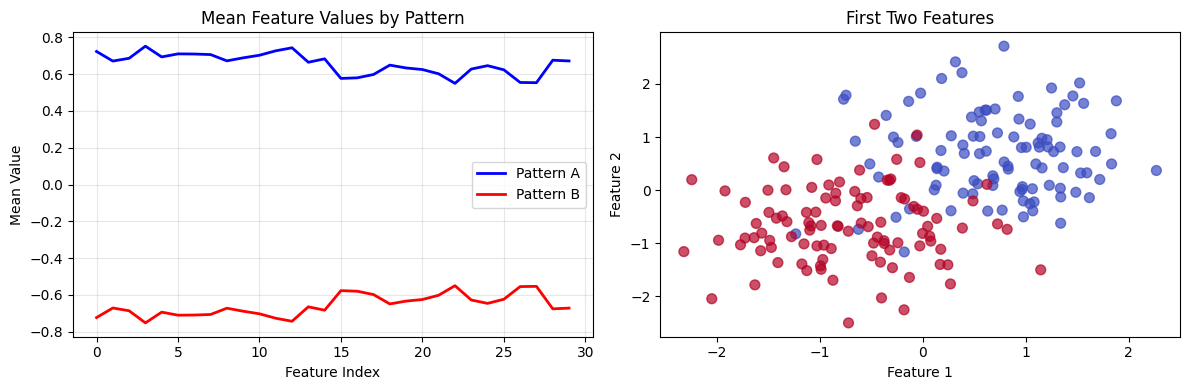

Dataset ready for autoencoder compression!


In [13]:
# Create Mock Dataset for Autoencoder Compression
print("Creating mock dataset for autoencoder dimensionality reduction...")

# Set random seed for reproducibility
np.random.seed(42)

# Dataset parameters
n_samples = 200
n_features = 30

# Create base dataset with some structure
X = np.random.randn(n_samples, n_features)

# Add distinct patterns to create interesting structure
# Group 1: Add positive bias to first half of features
X[:n_samples//2, :n_features//2] += 2.0

# Group 2: Add negative bias to second half of features  
X[n_samples//2:, n_features//2:] -= 1.5

# Add some noise
X += np.random.normal(0, 0.3, X.shape)

# Standardize the data
X = StandardScaler().fit_transform(X)

# Create labels for visualization
labels = np.repeat(["Pattern A", "Pattern B"], n_samples // 2)
if n_samples % 2 == 1:
    labels = np.append(labels, ["Pattern A"])

print(f"Mock dataset created:")
print(f"  Shape: {X.shape}")
print(f"  Features: {n_features}")
print(f"  Samples: {n_samples}")
print(f"  Labels: {np.unique(labels, return_counts=True)}")

# Visualize the dataset structure
plt.figure(figsize=(12, 4))

# Plot 1: Feature means by group
plt.subplot(1, 2, 1)
group_a = X[labels == "Pattern A"]
group_b = X[labels == "Pattern B"]
plt.plot(np.mean(group_a, axis=0), 'b-', label='Pattern A', linewidth=2)
plt.plot(np.mean(group_b, axis=0), 'r-', label='Pattern B', linewidth=2)
plt.title("Mean Feature Values by Pattern")
plt.xlabel("Feature Index")
plt.ylabel("Mean Value")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: First two features scatter plot
plt.subplot(1, 2, 2)
colors = (labels == "Pattern B").astype(int)
plt.scatter(X[:, 0], X[:, 1], c=colors, cmap="coolwarm", alpha=0.7, s=50)
plt.title("First Two Features")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

plt.tight_layout()
plt.show()

print("Dataset ready for autoencoder compression!")


In [ ]:

# Autoencoder for nonlinear dimensionality reduction
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=2):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64), nn.ReLU(), nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64), nn.ReLU(), nn.Linear(64, input_dim)
        )
    def forward(self, x):
        z = self.encoder(x)
        x_rec = self.decoder(z)
        return x_rec, z

In [ ]:

# Simple Autoencoder Training with Mock Dataset
print("Creating mock dataset for autoencoder training...")
np.random.seed(42)
n_samples, n_features = 200, 30  # Small dataset for fast training
X_mock = np.random.randn(n_samples, n_features)
# Add some structure to make it more interesting
X_mock[:n_samples//2] += 1.5  # Create two distinct groups
X_mock = StandardScaler().fit_transform(X_mock)

# Create mock conditions
conditions_mock = np.repeat(["Group A", "Group B"], n_samples // 2)

# Initialize autoencoder with mock data
input_dim = X_mock.shape[1]
ae = Autoencoder(input_dim)
optimizer = optim.Adam(ae.parameters(), lr=0.01)
criterion = nn.MSELoss()
tensor_data = torch.tensor(X_mock, dtype=torch.float32)
loader = DataLoader(TensorDataset(tensor_data, tensor_data), batch_size=16, shuffle=True)

print("Training autoencoder for 20 epochs...")
# Train the autoencoder
ae.train()
losses = []
for epoch in range(20):
    epoch_loss = 0
    for x, _ in loader:
        optimizer.zero_grad()
        x_rec, _ = ae(x)
        loss = criterion(x_rec, x)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    losses.append(epoch_loss / len(loader))
    if epoch % 5 == 0:
        print(f"Epoch {epoch:2d}, Loss: {losses[-1]:.4f}")

print("Training completed!")

# Extract latent representations
ae.eval()
with torch.no_grad():
    _, X_latent = ae(tensor_data)
    X_latent = X_latent.numpy()

# Plot results
plt.figure(figsize=(12, 5))

# Plot 1: Training loss
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title("Autoencoder Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True, alpha=0.3)

# Plot 2: Latent space
plt.subplot(1, 2, 2)
condition_colors_mock = (conditions_mock == "Group B").astype(int)
plt.scatter(X_latent[:, 0], X_latent[:, 1], c=condition_colors_mock, 
           cmap="coolwarm", alpha=0.7, s=50)
plt.title("Autoencoder Latent Space")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")

plt.tight_layout()
plt.show()

print(f"Final training loss: {losses[-1]:.4f}")
print(f"Latent space shape: {X_latent.shape}")
print("The autoencoder successfully learned a 2D representation!")



## ✅ Summary

In this lab you learned how to:
- Represent and scale gene expression data (RNA-seq)
- Apply PCA for variance-based projections
- Understand t-SNE and UMAP for nonlinear embeddings
- Cluster biological samples (k-Means, hierarchical)
- Use (and mock) autoencoders for deep feature compression

Next steps:
➡ Integrate these visualizations into multi-omics datasets  
➡ Use the embeddings for **classification and biomarker discovery**
